# Direct Model
## Setup

In [1]:
from data_utils import *
from train import * 

import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models
import matplotlib.pyplot as plt


# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

EDIBILITY = False
FINAL = True

USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    
else:
    device = torch.device('cpu')

dtype = torch.float32
torch.backends.cudnn.benchmark = True

print('use cuda = ', torch.cuda.is_available())
print('using device:', device)

use cuda =  True
using device: cuda


## Load Dataset

In [2]:
fname = "bolete.h5"
# fname = "bolete_lowres.h5"
data = load_bolete_data(fname)

print()
for k in data.keys():
    print(k, np.shape(data[k]))

ItemsViewHDF5(<HDF5 file "bolete.h5" (mode r)>)

bolete-characteristics (38, 1868)
bolete-edibility (5, 1868)
bolete-images (3, 512, 512, 1868)
bolete-labels (1868,)


## Split into train and test

In [3]:
if EDIBILITY:
    X_train, X_test, Y_train, Y_test, y_train, y_test = get_train_and_test(data, "bolete-edibility")
    M = Y_train.shape[1]
    Y_train = np.argmax(Y_train, axis=1)
    Y_test = np.argmax(Y_test, axis=1)
    
else:
    X_train, X_test, Y_train, Y_test, y_train, y_test = get_train_and_test(data, "bolete-labels")
    M = np.size(np.unique(Y_train))

N, H, W, C = X_train.shape

Y_train = Y_train.astype(np.long)
Y_test = Y_test.astype(np.long)

print(X_train.shape)
print(Y_train.shape)
print(y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(y_test.shape)

(1307, 3, 512, 512)
(1307,)
(1307,)
(561, 3, 512, 512)
(561,)
(561,)


## Define models

In [4]:
def simple_model():
    # copy final model from ass igment 2
    def flatten(x):
        """Flattens to [N, -1] where -1 is whatever it needs to be"""
        N = x.shape[0] # read in N, C, H, W
        return x.view(N, -1)  
        # "flatten" the C * H * W values into a single vector per image
    class Flatten(nn.Module):
        def forward(self, x):
            return flatten(x)

    channel_1 = 32
    channel_2 = 24
    channel_3 = 16
    hidden_dim = 150
    learning_rate = 3e-3 # 1e-2

    model = nn.Sequential(
        nn.Conv2d(C, channel_1, kernel_size=5, padding=2),
        # nn.GroupNorm(4,channel_1),
        nn.BatchNorm2d(channel_1),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Conv2d(channel_1, channel_2, kernel_size=3, padding=1),
        # nn.GroupNorm(4,channel_2),
        nn.BatchNorm2d(channel_2),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Conv2d(channel_2, channel_3, kernel_size=3, padding=1),
        # nn.GroupNorm(4,channel_3),
        nn.BatchNorm2d(channel_3),
        nn.ReLU(),
        nn.Dropout(0.1),
        Flatten(),
        nn.Linear(channel_3 * H * W, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, M)
    )
    
    return model

def freeze(model):
    for param in model.parameters():
        param.requires_grad = False
    return model

def modified_alexnet():
    model = models.alexnet(pretrained=True)
    model = freeze(model)

    # model.classifier[0] = ???
    model.classifier[6] = nn.Linear(in_features=4096, out_features=M, bias=True)
    # print(model)
    return model

def modified_googlenet():
    model = models.googlenet(pretrained=True)
    model = freeze(model)

    fc_in_feats = model.fc.in_features
    model.fc = nn.Linear(in_features=fc_in_feats, out_features=M, bias=True)
    # print(model)
    return model

def modified_resnext():
    model = models.resnext101_32x8d(pretrained=True)
    model = freeze(model)
    
    fc_in_feats = model.fc.in_features
    model.fc = nn.Linear(fc_in_feats, M)
    return model

## Define the loss function

In [5]:
loss_fn = nn.CrossEntropyLoss()

def pred_fn(scores):
    m = nn.Softmax(dim=1)
    return torch.argmax(m(scores), dim=1)

## Cross Validate on training data

In [6]:
# model = simple_model()
# model = modified_alexnet()
model = modified_googlenet()
# model = modified_resnext()


if EDIBILITY:
    optimizer = optim.RMSprop(
        model.parameters(),
        lr=5e-4,
        momentum=0.4,
        alpha=0.99
        )
else:
    optimizer = optim.RMSprop(
        model.parameters(),
        lr=1e-3,
        momentum=0.4,
        alpha=0.99
        )

transform = T.Compose([T.ToTensor()])
if EDIBILITY:
    batch_size = 128
    num_epochs = 60
else:
    batch_size = 8
    num_epochs = 40

num_folds = 1

torch.manual_seed(0)
history = cross_val(
    X_train=X_train,
    Y_train=Y_train,
    y_train=y_train,
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    pred_fn=pred_fn,
    batch_size=batch_size,
    num_epochs=num_epochs,
    num_classes=1,
    show_every=1,
    folds=num_folds,
    test_size=0.2,
    device=device,
    dtype=dtype,
    transform=None,
)

CV model on:  cuda
CV Fold:  1
Training model on:  cuda
Iter: 0
train Loss: 6.0241 Acc: 0.0124
Iter: 1
val Loss: 5.0707 Acc: 0.0305
Iter: 2
train Loss: 4.7341 Acc: 0.0565
Iter: 3
val Loss: 4.8172 Acc: 0.0573
Iter: 4
train Loss: 4.1629 Acc: 0.1196
Iter: 5
val Loss: 4.6237 Acc: 0.0992
Iter: 6
train Loss: 3.6532 Acc: 0.2258
Iter: 7
val Loss: 4.4770 Acc: 0.1145
Iter: 8
train Loss: 3.1963 Acc: 0.3349
Iter: 9
val Loss: 4.3379 Acc: 0.1183
Iter: 10
train Loss: 2.8441 Acc: 0.4029
Iter: 11
val Loss: 4.2403 Acc: 0.1260
Iter: 12
train Loss: 2.4728 Acc: 0.5062
Iter: 13
val Loss: 4.1598 Acc: 0.1641
Iter: 14
train Loss: 2.1649 Acc: 0.5952
Iter: 15
val Loss: 4.0854 Acc: 0.1718
Iter: 16
train Loss: 1.9207 Acc: 0.6421
Iter: 17
val Loss: 4.0558 Acc: 0.1870
Iter: 18
train Loss: 1.6823 Acc: 0.7014
Iter: 19
val Loss: 4.0176 Acc: 0.1718
Iter: 20
train Loss: 1.4871 Acc: 0.7579
Iter: 21
val Loss: 3.9880 Acc: 0.1947
Iter: 22
train Loss: 1.2828 Acc: 0.8182
Iter: 23
val Loss: 3.9843 Acc: 0.1908
Iter: 24
train Los

## Plot Training History

{'train_loss': [[6.024072704588968, 4.734054356442684, 4.162887001037598, 3.6532140138616973, 3.1962504122245825, 2.8440653816934978, 2.4728390664004825, 2.1648940458252097, 1.920680715022475, 1.6823058698736308, 1.4870591156790702, 1.282776426356375, 1.172748851776123, 1.0111261776189484, 0.9069480857210296, 0.8082758382176668, 0.7045356156723351, 0.6245063114394411, 0.5576067177872909, 0.5150483232651031, 0.442617309378665, 0.4047060725221223, 0.35475607902239387, 0.34666329063296886, 0.30250164464329987, 0.27736207355152476, 0.2597001348100781, 0.23328209841650638, 0.22799760123188986, 0.19130535962764156, 0.19880410538335735, 0.17148148065263574, 0.159279104268722, 0.15829273861561094, 0.16134873906676278, 0.13855440652256376, 0.13286396989411714, 0.11617499533595081, 0.1136275300711536, 0.1024484543994283]], 'val_loss': [[5.0706540719243405, 4.817186537589736, 4.623709980768102, 4.4769616345412855, 4.337874882093823, 4.240329214634786, 4.15980055131985, 4.085430916939073, 4.055812

True

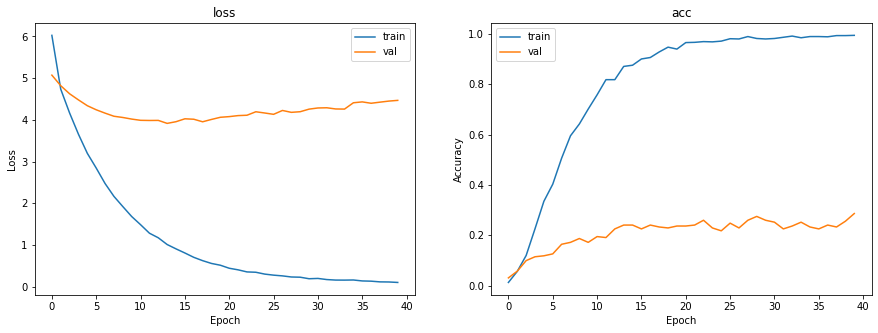

In [7]:
fig, axes = plt.subplots(1, 2, figsize=[15,5], sharex=False, sharey=False)
axes[0].set_ylabel("Loss")
axes[1].set_ylabel("Accuracy")

plotnum = 0

phase = ["train", "val"]
for s in ["loss", "acc"]:
    for a in phase:
        axes[plotnum].set_title(s)
        axes[plotnum].set_xlabel("Epoch")
        axes[plotnum].plot(np.mean(history[a+'_'+s], axis=0))
        axes[plotnum].legend(phase)
    plotnum += 1
print(history, "direct_"+fname, EDIBILITY)
ed = "ed_" if EDIBILITY else ""
save_history_data(history, "direct_"+ed+fname, edibility=EDIBILITY, num_folds=num_folds)

## Train on all the data

In [8]:
if FINAL:
    model = modified_googlenet()
    if EDIBILITY:
        optimizer = optim.RMSprop(
            model.parameters(),
            lr=5e-4,
            momentum=0.4,
            alpha=0.99
            )
    else:
        optimizer = optim.RMSprop(
            model.parameters(),
            lr=1e-3,
            momentum=0.4,
            alpha=0.99
            )
        if fname == "bolete.h5":
            num_epochs = 15
        else:
            num_epochs = 7
    
    dataloader_tr = get_loader(X_train, Y_train, batch_size)
    dataloader_val = get_loader(X_test, Y_test, batch_size)
    dataloaders = {"train":dataloader_tr, "val":dataloader_val}
    train_acc_history, train_loss_history, val_acc_history, val_loss_history = train_model(
        model,
        optimizer,
        dataloaders,
        loss_fn,
        pred_fn,
        num_epochs,
        num_classes=1,
        show_every=1,
        device=device,
        dtype=dtype,
    )

Training model on:  cuda
Iter: 0
train Loss: 5.8596 Acc: 0.0145
Iter: 1
val Loss: 5.1222 Acc: 0.0303
Iter: 2
train Loss: 4.6551 Acc: 0.0528
Iter: 3
val Loss: 4.8488 Acc: 0.0535
Iter: 4
train Loss: 4.0831 Acc: 0.1262
Iter: 5
val Loss: 4.6453 Acc: 0.0713
Iter: 6
train Loss: 3.5832 Acc: 0.2196
Iter: 7
val Loss: 4.5095 Acc: 0.0945
Iter: 8
train Loss: 3.1511 Acc: 0.2999
Iter: 9
val Loss: 4.3702 Acc: 0.1301
Iter: 10
train Loss: 2.7598 Acc: 0.4124
Iter: 11
val Loss: 4.2743 Acc: 0.1462
Iter: 12
train Loss: 2.4127 Acc: 0.5011
Iter: 13
val Loss: 4.1933 Acc: 0.1622
Iter: 14
train Loss: 2.1673 Acc: 0.5669
Iter: 15
val Loss: 4.1543 Acc: 0.1693
Iter: 16
train Loss: 1.9071 Acc: 0.6358
Iter: 17
val Loss: 4.1143 Acc: 0.1747
Iter: 18
train Loss: 1.6695 Acc: 0.6855
Iter: 19
val Loss: 4.1078 Acc: 0.1783
Iter: 20
train Loss: 1.5087 Acc: 0.7261
Iter: 21
val Loss: 4.0407 Acc: 0.1907
Iter: 22
train Loss: 1.3317 Acc: 0.7682
Iter: 23
val Loss: 4.0625 Acc: 0.1996
Iter: 24
train Loss: 1.1681 Acc: 0.8125
Iter: 25


In [9]:
if FINAL:
    final_history = {
        "train_acc": [train_acc_history],
        "train_loss": [train_loss_history],
        "val_acc": [val_acc_history],
        "val_loss": [val_loss_history],
    }
    ed = "ed_" if EDIBILITY else ""
    save_history_data(final_history, "direct_"+ed+"final_"+fname, edibility=EDIBILITY, num_folds=1)

history_data/direct_final_bolete.h5_history.csv


## Evaluate 

In [10]:
if FINAL:
    X, Y, y = X_test, Y_test, y_test
else:
    X, Y, y = get_val(X_train, Y_train, y_train)

scores, y_pred, y_true, y_labels = evaluate(
    X,  # images
    Y,  # output
    y,  # labels
    model,
    out_dim=M,
    pred_fn=pred_fn,
    device=device,
    transform=None,
)
if EDIBILITY:
    save_raw_eval_data(scores, y_pred, y_true, y_labels, "direct_ed_"+fname)
else:
    save_raw_eval_data(scores, y_pred, y_true, y_labels, "direct_"+fname)

Evaluating model on:  cuda


### Check status of GPU Memory for Debugging Purposes

In [11]:
import torch
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    except:
        pass

<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torc